# Imports and data extracting

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, Pool
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost.utils import eval_metric
import pickle

### df_сampaigns -> факт коммуникаций с баерами

In [4]:
df_campaigns = pd.read_feather('campaigns.feather')
df_campaigns.head()

,smt_decision_makerid,delivery_date,hash,campaign_name,segment_name,ab_group,tag_channel,tag_category,tag_campaign_type,tag_product,tag_project_type,tag_project_region,tag_discount_flag,tag_chain_flag,tag_model_flag,target_event,tag_realestate_flag
0,d07201565c46a7ff8544574ad3410cc8,2024-12-05,91e093035c50c368832552e8b174e740,[prod] [batch] [241204] [SMS] Первичная недвиж...,DSML-1844,target,sms,RealEstate,Active,realestate,not_izhs,mimo,not_discount,not_chain,model,sale,realestate
1,d07201565c46a7ff8544574ad3410cc8,2024-12-03,91e093035c50c368832552e8b174e740,[run] [241031] Первичная недвижимость После зв...,None,target,wa,RealEstate,Active,realestate,not_izhs,all,not_discount,not_chain,not_model,appointment,realestate
2,cd71ba6d85a7e0c379e54892a6b931de,2024-10-02,4df189d22038fd188fef0ec54a9cba6c,[batch] [241002] [SMS] Первичная недвижимость ...,DSML-1814,target,sms,RealEstate,Active,realestate,not_izhs,all,not_discount,not_chain,model,appointment,realestate
3,340dd300a3093e8120264d701ca9f73c,2024-12-03,ef401fc6177a7592861c437cb6ce728b,[batch] [241203] [SMS] [МСК] Первичная недвижи...,CMPG-3843,control,sms,RealEstate,Active,realestate,not_izhs,mimo,not_discount,chain,not_model,call,realestate
4,340dd300a3093e8120264d701ca9f73c,2024-12-10,ef401fc6177a7592861c437cb6ce728b,[batch] [241203] [SMS] [МСК] Первичная недвижи...,CMPG-3843,control,sms,RealEstate,Active,realestate,not_izhs,mimo,not_discount,chain,not_model,call,realestate


In [6]:
df_campaigns.drop_duplicates(inplace = True)

In [7]:
df_campaigns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1428378 entries, 0 to 1999635
Data columns (total 17 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   smt_decision_makerid  1428378 non-null  object
 1   delivery_date         1428378 non-null  object
 2   hash                  1428378 non-null  object
 3   campaign_name         1428378 non-null  object
 4   segment_name          1428378 non-null  object
 5   ab_group              1428378 non-null  object
 6   tag_channel           1428378 non-null  object
 7   tag_category          1428378 non-null  object
 8   tag_campaign_type     1428378 non-null  object
 9   tag_product           1428378 non-null  object
 10  tag_project_type      1428378 non-null  object
 11  tag_project_region    1428378 non-null  object
 12  tag_discount_flag     1428378 non-null  object
 13  tag_chain_flag        1428378 non-null  object
 14  tag_model_flag        1428378 non-null  object
 15  tar

In [10]:
df_campaigns['delivery_date'] = pd.to_datetime(df_campaigns['delivery_date'])

In [12]:
df_campaigns.target_event.value_counts()

target_event
call           934124
appointment    231710
sale            95000
reservation     86139
клик            81405
Name: count, dtype: int64

In [14]:
# sale = deal ???
df_campaigns['target_event'] = df_campaigns['target_event'].replace({'sale': 'deal'})

In [16]:
df_campaigns = df_campaigns[df_campaigns.target_event.isin(['call','appointment','reservation','deal'])]

In [18]:
df_campaigns['previous_sunday'] = df_campaigns['delivery_date'].apply(lambda x: x - pd.to_timedelta((x.weekday() + 1) % 7, unit='D'))

In [19]:
print(f' Уникальных клиентов в датасете {df_campaigns.smt_decision_makerid.nunique()}')

 Уникальных клиентов в датасете 443774


In [20]:
print(f' Уникальных коммуникаций в датасете {len(df_campaigns)}')

 Уникальных коммуникаций в датасете 1346973


In [21]:
print(f' Коммуникации собраны с {df_campaigns.delivery_date.min()} до {df_campaigns.delivery_date.max()}')

 Коммуникации собраны с 2024-09-02 00:00:00 до 2024-12-31 00:00:00


### df_targets - действия баеров по воронке

In [56]:
df_targets = pd.read_feather('targets.feather')
df_targets.head()

,smt_decision_makerid,report_date,event,tag_event_feature,tag_event_project_type,tag_event_project_region
23,4f9080e1ab09fba6dcbbda752005bde9,2024-10-21 07:52:33,call,outgoing__unknown__secondary,None,None
24,4f9080e1ab09fba6dcbbda752005bde9,2024-10-19 13:39:08,call,outgoing__unknown__secondary,None,None
25,4f9080e1ab09fba6dcbbda752005bde9,2024-10-19 13:35:00,call,ingoing__unknown__primary,None,None
26,4f9080e1ab09fba6dcbbda752005bde9,2024-10-19 13:39:05,decision_maker,None,None,None
28,8c7a245f36d9d5104f14c0edb900d5f5,2024-09-26 12:13:32,decision_maker,None,None,None


In [58]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1671854 entries, 23 to 7761312
Data columns (total 6 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   smt_decision_makerid      1671854 non-null  object        
 1   report_date               1671854 non-null  datetime64[ns]
 2   event                     1671854 non-null  object        
 3   tag_event_feature         1303597 non-null  object        
 4   tag_event_project_type    857872 non-null   object        
 5   tag_event_project_region  857872 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 89.3+ MB


In [60]:
df_targets['event_dt'] = pd.to_datetime(df_targets['report_date']).dt.date

In [62]:
df_targets.drop_duplicates(inplace = True)

In [63]:
print(f'Всего ЦД в датасете {len(df_targets)}')

Всего ЦД в датасете 1662142


In [64]:
print(f'Уникальных клиентов в датасете {df_targets.smt_decision_makerid.nunique()}')

Уникальных клиентов в датасете 401628


In [68]:
print(f'Уникальных цд в датасете {df_targets.event.nunique()}')

Уникальных цд в датасете 13


In [70]:
print(f' ЦД собраны с {df_targets.report_date.min()} до {df_targets.report_date.max()}')

 ЦД собраны с 2024-09-01 00:03:59 до 2024-12-31 23:49:47


In [72]:
df_targets.event.value_counts()

event
call              1044409
decision_maker     271063
specific_pick      134872
appointment         71377
wishlist            66628
reservation         20043
deal                16961
sale                14100
residential          8706
mortgage_app         8099
web_app              2977
tradein_app          2841
levelup_app            66
Name: count, dtype: int64

In [74]:
# нам нужны только 4 -> звонок, встреча, бронь, покупка (?)
# call, appointment, reservation, deal

In [76]:
# фильтруем df_targets, оставляя только нужные цд

In [78]:
# объединяю sale и deal
df_targets['event'] = df_targets['event'].replace({'sale': 'deal'})

In [80]:
df_targets = df_targets[df_targets.event.isin(['call', 'appointment','reservation','deal'])]

In [82]:
print(f'Всего ЦД в датасете {len(df_targets)}')

Всего ЦД в датасете 1166890


In [84]:
print(f'Уникальных клиентов в датасете {df_targets.smt_decision_makerid.nunique()}')

Уникальных клиентов в датасете 343719


In [86]:
print(f'Уникальных цд в датасете {df_targets.event.nunique()}')

Уникальных цд в датасете 4


In [88]:
print(f' ЦД собраны с {df_targets.report_date.min()} до {df_targets.report_date.max()}')

 ЦД собраны с 2024-09-01 00:03:59 до 2024-12-31 23:36:16


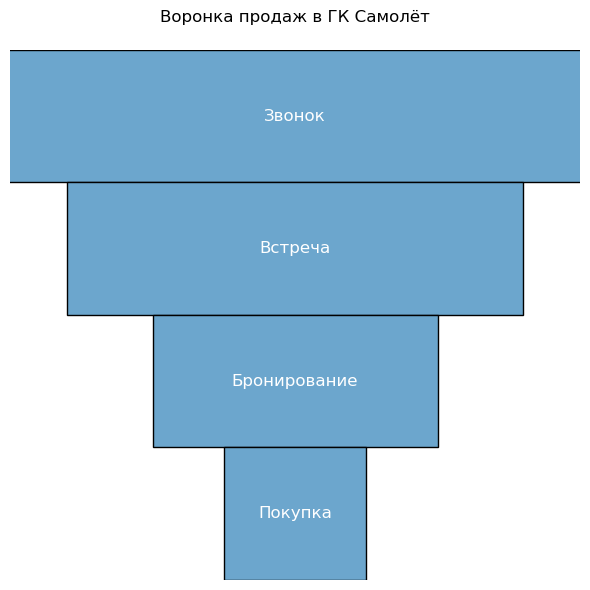

In [379]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Шаги воронки и относительные ширины
levels = ["Звонок", "Встреча", "Бронирование", "Покупка"]
widths = [1.5, 0.8, 0.5, 0.25]  # относительные ширины слоёв
y_positions = [0, 1, 2, 3]  # расположение слоёв (0 сверху, 3 снизу)

# Приятный пастельный цвет
fill_color = "#6CA6CD"  # небесно-голубой

fig, ax = plt.subplots(figsize=(6, 6))

# Рисуем слои воронки сверху вниз
for y, width, label in zip(y_positions, widths, levels):
    left = (1 - width) / 2
    right = left + width
    polygon = Polygon([[left, y], [right, y], [right, y+1], [left, y+1]],
                       closed=True, facecolor=fill_color, edgecolor='black')
    ax.add_patch(polygon)
    ax.text(0.5, y + 0.5, label, va='center', ha='center', fontsize=12, color='white')

# Инвертируем ось Y, чтобы слой y=0 был сверху
ax.set_xlim(0, 1)
ax.set_ylim(0, 4)
ax.invert_yaxis()
ax.axis('off')
plt.title("Воронка продаж в ГК Самолёт", pad=20)
plt.tight_layout()
plt.show()


### duf -> dataframe user features

In [90]:
# до 400 важных фичей на клиента
duf = pd.read_feather('data_for_students_features_sample_400cols.feather')
duf.head()

,specific_picks__g_client__specific_picks__count__180D,specific_picks__g_client__specific_picks__count__365D,specific_picks__g_client__specific_picks__count__THIS_MONTH,specific_picks__g_client__specific_picks__count__ALL_TIME,specific_picks__g_client__sp_buy_rent__count__60D,specific_picks__g_client__sp_buy_rent__count__90D,specific_picks__g_client__sp_buy_rent__count__180D,specific_picks__g_client__sp_buy_rent__count__365D,specific_picks__g_client__sp_buy_rent__count__THIS_MONTH,specific_picks__g_client__sp_buy_rent__count__ALL_TIME,...,wishlists__g_client__crm_objects__smt_sale_price_rooms_2__avg__avg__180D,wishlists__g_client__crm_objects__flag_finishing__avg__avg__180D,wishlists__g_client__crm_objects__flag_finishing__avg__avg__365D,wishlists__g_client__crm_objects__flag_finishing__avg__avg__ALL_TIME,wishlists__g_client__wl_createdon__min__ALL_TIME,wishlists__g_client__wl_createdon__max__180D,wishlists__g_client__wl_createdon__max__ALL_TIME,smt_decision_makerid_hash,delivery_date,report_date
0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cf95f46d6f8c1c08090402da8bcc8866,2024-10-16,2024-10-13
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a024eeadd2a9bc8597d91126a11df815,2024-12-18,2024-12-15
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823fc0f3c42feb6fdfa437ef138f71af,2024-12-09,2024-12-08
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29d749a479f6a50c12f66a66e74f873f,2024-10-29,2024-10-27
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17f4b76507545dab3ace58ecee673269,2024-10-11,2024-10-06


In [91]:
# меняем название на привычный user_id
duf.rename(columns={'smt_decision_makerid_hash': 'smt_decision_makerid'}, inplace=True)

In [92]:
# duf['previous_sunday'] = duf['delivery_date'].apply(lambda x: x - pd.to_timedelta((x.weekday() + 1) % 7, unit='D'))

In [96]:
duf['report_date'] = pd.to_datetime(duf['report_date'])
duf['delivery_date'] = pd.to_datetime(duf['delivery_date'])

In [98]:
# берём строки из duf только до 15.12, потому что таргет до конца 24
duf = duf[duf.report_date<='2024-12-15']

In [99]:
# убираем повторяющиеся фичи юзера, которые получились в датасете в результате нескольких рассылок
duf.drop_duplicates(subset=['smt_decision_makerid', 'report_date'], inplace=True)

In [101]:
# duf - фичи клиентов на воскресенье, предшествующее коммуникации из df_campaigns
# одна строка - клиент + фичи на дату

In [104]:
duf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1143647 entries, 0 to 1390846
Columns: 363 entries, specific_picks__g_client__specific_picks__count__180D to report_date
dtypes: datetime64[ns](2), float32(360), object(1)
memory usage: 1.6+ GB


In [106]:
print(f' Всего строк в датасете {len(duf)}')

 Всего строк в датасете 1143647


In [108]:
print(f' Уникальных клиентов в датасете {duf.smt_decision_makerid.nunique()}')

 Уникальных клиентов в датасете 435515


In [110]:
print(f' Фичи собраны с {duf.report_date.min()} до {duf.report_date.max()}')

 Фичи собраны с 2024-09-01 00:00:00 до 2024-12-15 00:00:00


In [112]:
duf.drop(columns = 'delivery_date', inplace = True)

#### Делю на VAL и TEST датасеты

In [114]:
# Датасет для подбора гиперпараметров

In [116]:
# всего 1.1 млн -> тысяч по 150 на выборки
len(duf)

1143647

In [118]:
val_data = duf[(duf.report_date == '2024-12-08')][['smt_decision_makerid','report_date']]

In [120]:
val_data.to_excel('x_val_set_for_params_tuning.xlsx')

In [121]:
# Датасет для финальной проверки

In [122]:
test_data = duf[(duf.report_date == '2024-12-15')][['smt_decision_makerid','report_date']]

In [123]:
test_data.to_excel('x_test_set_for_metrics_check.xlsx')

## Логика

In [132]:
# Делаю скоринг для коммуникаций

# На входе -> фичи пользователя + тэги коммуникации
# На выходе -> вероятность каждого целевого действия (звонок, встреча, бронь, покупка)


In [133]:
# Обучение:
# X - пользователь + коммуникация
# y_i - факт цд в окне 7/14 дней от delivery_date

## Готовлю данные

In [130]:
tags = ['tag_channel', 'tag_category',
       'tag_campaign_type', 'tag_product', 'tag_project_type',
       'tag_project_region', 'tag_discount_flag', 'tag_chain_flag',
       'tag_model_flag', 'tag_realestate_flag']
all_camp_features = ['target_event'] + tags

In [176]:
main_camp_features = ['target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']

In [178]:
# user features with communication
# одна строка - smt_decision_makerid+report_date+delivery_date

df_uf_w_com = duf.merge(df_campaigns[['smt_decision_makerid','delivery_date','previous_sunday']+main_camp_features],
        left_on = ['smt_decision_makerid','report_date'], right_on = ['smt_decision_makerid','previous_sunday'])

In [180]:
# теперь надо посчитать факт целевого действия в окнах от delivery_date
df_del = df_uf_w_com[['smt_decision_makerid','delivery_date']].copy()

df_del['end_date_7'] = df_del['delivery_date'] + pd.Timedelta(days=7)
df_del['end_date_14'] = df_del['delivery_date'] + pd.Timedelta(days=14)

# Переименуем поля, чтобы не было конфликтов при merge
df_targets_renamed = df_targets.rename(columns={'report_date': 'event_date'})

In [182]:
# Сделаем merge по user_id, затем отфильтруем по диапазону дат
merged = df_del.merge(df_targets_renamed, on='smt_decision_makerid', how='left')
merged = merged[
    # цд после коммуникации
    (merged['event_date'] >= merged['delivery_date']) & 
    # для звонка и встречи окно 7 дней
    (((merged['event'].isin(['call','appointment'])) & (merged['event_date'] <= merged['end_date_7'])) | 
    # для брони и сделки 14 дней
    ((merged['event'].isin(['reservation','deal'])) & (merged['event_date'] <= merged['end_date_14'])))
]

In [184]:
# Создадим сводную таблицу, где по каждой записи в df_del будет указано наличие события
event_flags = (
    merged.groupby(['smt_decision_makerid', 'delivery_date', 'event']).size()
    .unstack(fill_value=0) # в df 
    .clip(upper=1)  # превращаем количество в 1/0
    .reset_index()
)

In [186]:
# Объединим с исходной таблицей
final_data = df_uf_w_com.merge(event_flags, on=['smt_decision_makerid', 'delivery_date'], how='left')

# final_data NaN на 0 — там, где не было совпадений
final_data[['call', 'appointment', 'reservation', 'deal']] = final_data[
    ['call', 'appointment', 'reservation', 'deal']
].fillna(0).astype(int)

final_data

,specific_picks__g_client__specific_picks__count__180D,specific_picks__g_client__specific_picks__count__365D,specific_picks__g_client__specific_picks__count__THIS_MONTH,specific_picks__g_client__specific_picks__count__ALL_TIME,specific_picks__g_client__sp_buy_rent__count__60D,specific_picks__g_client__sp_buy_rent__count__90D,specific_picks__g_client__sp_buy_rent__count__180D,specific_picks__g_client__sp_buy_rent__count__365D,specific_picks__g_client__sp_buy_rent__count__THIS_MONTH,specific_picks__g_client__sp_buy_rent__count__ALL_TIME,...,previous_sunday,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag,appointment,call,deal,reservation
0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,...,2024-10-13,call,nbo,not_izhs,not_chain,not_model,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-12-15,call,realestate,not_izhs,chain,not_model,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,2024-12-08,deal,mortgage,not_izhs,not_chain,model,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-10-27,call,realestate,not_izhs,chain,not_model,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-10-06,call,realestate,not_izhs,chain,not_model,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136107,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2024-09-29,deal,realestate,not_izhs,not_chain,model,0,0,0,0
1136108,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2024-09-29,call,realestate,not_izhs,not_chain,not_model,0,0,0,0
1136109,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,2024-10-06,call,nbo,not_izhs,not_chain,not_model,0,0,0,0
1136110,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,...,2024-12-15,call,realestate,not_izhs,chain,not_model,0,0,0,0


In [216]:
# оставляю коммуникации только как в filtered_camps

# Делю на 2 ноута:

# 1. Этот - тупо скоринг по вероятности сделки 

# 2. По юзеру предсказываю склонность, дальше бизнес-правила и выбираю оффер по цд

In [190]:
# campaign_filters = (final_data.tag_channel == 'sms')&(final_data.target_event != 'reservation')

In [192]:
main_camp_features = ['target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']

In [194]:
# res_camps = final_data.groupby(all_camp_features)[['delivery_date']].agg(['max', 'min','count']).reset_index()
res_camps = final_data.groupby(main_camp_features)[['delivery_date']].agg(['max', 'min','count']).reset_index()

In [196]:
res_camps.rename(columns={'min': 'min_dt', 
                        'max': 'max_dt',
                        'count': 'camps'}, inplace = True)

In [198]:
res_camps[(res_camps.delivery_date.max_dt >= '2024-12-15')&(res_camps.delivery_date.min_dt < '2024-12-08')].delivery_date.camps.sum()

720778

In [200]:
filtered_camps = res_camps[(((res_camps.delivery_date.max_dt >= '2024-12-08')&(res_camps.delivery_date.min_dt < '2024-12-08'))\
            | ((res_camps.target_event == 'deal')&(res_camps.tag_product == 'realestate')))
            & (res_camps.tag_product != 'lost_leads')].drop('delivery_date', axis = 1)

/var/folders/z2/2_vkl0857zddhqnj2vn7yx440000gn/T/ipykernel_20504/3436734710.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  & (res_camps.tag_product != 'lost_leads')].drop('delivery_date', axis = 1)


In [202]:
filtered_camps

,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag
,,,,,
2,appointment,nbo,not_izhs,not_chain,not_model
5,appointment,realestate,not_izhs,not_chain,not_model
8,call,commercial,not_izhs,chain,not_model
10,call,izhs,izhs,chain,not_model
11,call,mortgage,not_izhs,not_chain,not_model
14,call,realestate,not_izhs,chain,not_model
18,deal,mortgage,not_izhs,not_chain,model
19,deal,realestate,not_izhs,not_chain,model
22,reservation,not_defined,not_izhs,not_chain,not_model


In [204]:
filtered_camps.columns = filtered_camps.columns.droplevel(1)

In [206]:
filtered_camps.reset_index(drop=True, inplace = True)

In [208]:
filtered_camps

,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag
0,appointment,nbo,not_izhs,not_chain,not_model
1,appointment,realestate,not_izhs,not_chain,not_model
2,call,commercial,not_izhs,chain,not_model
3,call,izhs,izhs,chain,not_model
4,call,mortgage,not_izhs,not_chain,not_model
5,call,realestate,not_izhs,chain,not_model
6,deal,mortgage,not_izhs,not_chain,model
7,deal,realestate,not_izhs,not_chain,model
8,reservation,not_defined,not_izhs,not_chain,not_model
9,reservation,realestate,not_izhs,not_chain,model


In [210]:
final_data = final_data.merge(filtered_camps)

In [214]:
final_data.columns[360:]

Index(['smt_decision_makerid', 'report_date', 'delivery_date',
       'previous_sunday', 'target_event', 'tag_product', 'tag_project_type',
       'tag_chain_flag', 'tag_model_flag', 'appointment', 'call', 'deal',
       'reservation'],
      dtype='object')

In [182]:
# final_data = final_data.drop(columns = ['target_event', 'tag_channel', 'tag_campaign_type'
#             ,'tag_product', 'tag_project_type', 'tag_discount_flag','tag_chain_flag'])

In [236]:
train_full = final_data[final_data.report_date < '2024-12-08']

X_train = train_full.drop(columns=['call','appointment','deal','reservation','smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()

y_train = train_full[['call','appointment','reservation','deal']].to_numpy()

In [237]:
train_full[['call','appointment','reservation','deal']].mean()

call           0.057921
appointment    0.013944
reservation    0.004647
deal           0.003848
dtype: float64

In [238]:
val_full = final_data[final_data.report_date == '2024-12-08']

X_val = val_full.drop(columns=['call','appointment','deal','reservation','smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()
y_val = val_full[['call','appointment','reservation','deal']].to_numpy()

In [239]:
val_full[['call','appointment','reservation','deal']].mean()

call           0.050911
appointment    0.012710
reservation    0.004132
deal           0.003496
dtype: float64

In [240]:
test_full = final_data[final_data.report_date > '2024-12-08']

X_test = test_full.drop(columns=['call','appointment','deal','reservation','smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()
y_test = test_full[['call','appointment','reservation','deal']].to_numpy()

In [241]:
# меньше CR на тесте, близко к нг - праздники
test_full[['call','appointment','reservation','deal']].mean()

call           0.032880
appointment    0.006589
reservation    0.002543
deal           0.002739
dtype: float64

In [242]:
len(X_train), len(X_val), len(X_test)

(534557, 114711, 169069)

In [252]:
final_data.groupby(main_camp_features)[['call','appointment','reservation','deal']].agg(['mean', 'count'])

call  \
                                                                             mean   
target_event tag_product tag_project_type tag_chain_flag tag_model_flag             
appointment  nbo         not_izhs         not_chain      not_model       0.028557   
             realestate  not_izhs         not_chain      not_model       0.327950   
call         commercial  not_izhs         chain          not_model       0.013220   
             izhs        izhs             chain          not_model       0.016691   
             mortgage    not_izhs         not_chain      not_model       0.023392   
             realestate  not_izhs         chain          not_model       0.020649   
deal         mortgage    not_izhs         not_chain      model           0.147616   
             realestate  not_izhs         not_chain      model           0.066095   
reservation  not_defined not_izhs         not_chain      not_model       0.088275   
             realestate  not_izhs         not_chain      model           0.127048   

                                                                                 \
                                                                          count   
target_event tag_product tag_project_type tag_chain_flag tag_model_flag           
appointment  nbo         not_izhs         not_chain      not_model        39815   
             realestate  not_izhs         not_chain      not_model        53688   
call         commercial  not_izhs         chain          not_model         5068   
             izhs        izhs             chain          not_model        32891   
             mortgage    not_izhs         not_chain      not_model        31549   
             realestate  not_izhs         chain          not_model       540122   
deal         mortgage    not_izhs         not_chain      model            17261   
             realestate  not_izhs         not_chain      model            49232   
reservation  not_defined not_izhs         not_chain      not_model        22713   
             realestate  not_izhs         not_chain      model            25998   

                                                                        appointment  \
                                                                               mean   
target_event tag_product tag_project_type tag_chain_flag tag_model_flag               
appointment  nbo         not_izhs         not_chain      not_model         0.004496   
             realestate  not_izhs         not_chain      not_model         0.106039   
call         commercial  not_izhs         chain          not_model         0.001579   
             izhs        izhs             chain          not_model         0.002980   
             mortgage    not_izhs         not_chain      not_model         0.004342   
             realestate  not_izhs         chain          not_model         0.003660   
deal         mortgage    not_izhs         not_chain      model             0.019813   
             realestate  not_izhs         not_chain      model             0.009750   
reservation  not_defined not_izhs         not_chain      not_model         0.031480   
             realestate  not_izhs         not_chain      model             0.015270   

                                                                                 \
                                                                          count   
target_event tag_product tag_project_type tag_chain_flag tag_model_flag           
appointment  nbo         not_izhs         not_chain      not_model        39815   
             realestate  not_izhs         not_chain      not_model        53688   
call         commercial  not_izhs         chain          not_model         5068   
             izhs        izhs             chain          not_model        32891   
             mortgage    not_izhs         not_chain      not_model        31549   
             realestate  not_izhs         chain          not_model       540122   
deal        

## Multi-label модель

In [272]:
campaigns_features_idx = [360,361,362,363,364]

In [292]:
params = {
    # база для любой модели
    'iterations':    500,
    'learning_rate': 0.05,
    'random_state':42,
    'early_stopping_rounds': 100,
    'verbose':100,
    'cat_features':campaigns_features_idx,
    # метрики для предсказания нескольких классов 
    'loss_function': 'MultiCrossEntropy',
    'eval_metric':   'MultiCrossEntropy',
    # боремся с переобучением
    'depth':         6,
    'l2_leaf_reg':   2,
    # 'bootstrap_type':'Bernoulli',
    # 'subsample':     0.8,
    # для лучшей работы с несколькими классами
    'use_best_model': True,
    'class_names':['call', 'appointment', 'reservation', 'deal']
}

In [294]:
target_action_model = CatBoostClassifier(**params)

In [296]:
target_action_model.fit(X_train, y_train,
        eval_set=(X_val, y_val),
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5832298	test: 0.5830302	best: 0.5830302 (0)	total: 757ms	remaining: 6m 17s
100:	learn: 0.0503329	test: 0.0444981	best: 0.0444981 (100)	total: 1m 11s	remaining: 4m 42s
200:	learn: 0.0485050	test: 0.0433667	best: 0.0433667 (200)	total: 2m 20s	remaining: 3m 28s
300:	learn: 0.0474213	test: 0.0429865	best: 0.0429865 (300)	total: 3m 28s	remaining: 2m 17s
400:	learn: 0.0467487	test: 0.0427751	best: 0.0427751 (400)	total: 4m 36s	remaining: 1m 8s
499:	learn: 0.0461205	test: 0.0426392	best: 0.0426392 (499)	total: 5m 42s	remaining: 0us

bestTest = 0.04263923314
bestIteration = 499



In [297]:
test_predict = target_action_model.predict(X_test)
probs = target_action_model.predict_proba(X_test)

In [298]:
target_action_model.save_model('target_action_model.bin')

In [299]:
# target_action_model.load_model('target_action_model.bin')
# print(target_action_model.get_params())
# print(target_action_model.random_seed_)

In [300]:
# теперь считаем метрики для каждого класса

In [301]:
# подбираем трешхолды по единому правилу

In [302]:
target_action_model.get_feature_importance(prettified=True)[:10]

,Feature Id,Importances
0,363,14.692076
1,360,10.007610
2,24,4.983170
3,26,4.109664
4,361,3.695311
5,315,2.751852
6,364,2.613589
7,148,2.421908
8,167,2.131272
9,139,1.600345



Target: call
AUC       : 0.810
Trashhold = default 0.5
Accuracy  : 0.826
Precision : 0.099
Recall    : 0.529
F1-score  : 0.166

Target: appointment
AUC       : 0.768
Trashhold = default 0.5
Accuracy  : 0.954
Precision : 0.008
Recall    : 0.048
F1-score  : 0.014

Target: reservation
AUC       : 0.765
Trashhold = default 0.5
Accuracy  : 0.997
Precision : 0.000
Recall    : 0.000
F1-score  : 0.000

Target: deal
AUC       : 0.819
Trashhold = default 0.5
Accuracy  : 0.997
Precision : 0.333
Recall    : 0.004
F1-score  : 0.009

Average Metrics:
AUC       : 0.7904
Accuracy  : 0.9436
Precision : 0.1100
Recall    : 0.1456
F1-score  : 0.0472


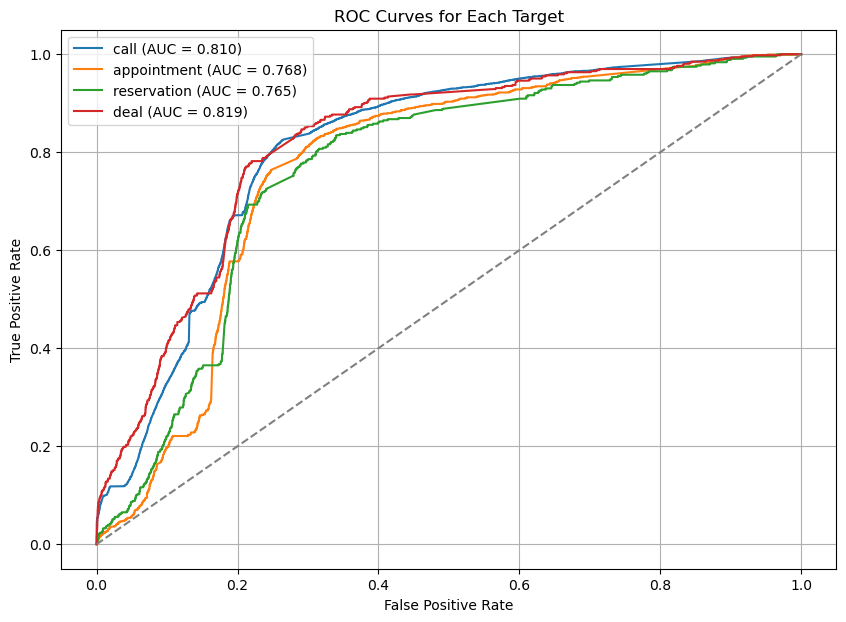

In [304]:
# Метрики и графики для каждого таргета
def plot_roc_curve(y_true, y_pred, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_true, y_pred):.3f})')

test_auc, test_acc, test_prec, test_rec, test_f1 = [], [], [], [], []

plt.figure(figsize=(10, 7))
for i, target in enumerate(target_action_model.classes_):
    y_true = y_test[:,i]
    y_prob = probs[:,i]
    y_pred = (y_prob >= 0.5).astype(int)

    # Метрики 
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    test_auc.append(auc)
    test_acc.append(acc)
    test_prec.append(prec)
    test_rec.append(rec)
    test_f1.append(f1)

    print(f"\nTarget: {target}")
    print(f"AUC       : {auc:.3f}")
    print(f"Trashhold = default 0.5")
    print(f"Accuracy  : {acc:.3f}")
    print(f"Precision : {prec:.3f}")
    print(f"Recall    : {rec:.3f}")
    print(f"F1-score  : {f1:.3f}")

    # Рисуем ROC
    plot_roc_curve(y_true, y_prob, target)
    
# Общий вывод
print("\nAverage Metrics:")
print(f"AUC       : {np.mean(test_auc):.4f}")
print(f"Accuracy  : {np.mean(test_acc):.4f}")
print(f"Precision : {np.mean(test_prec):.4f}")
print(f"Recall    : {np.mean(test_rec):.4f}")
print(f"F1-score  : {np.mean(test_f1):.4f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Target')
plt.legend()
plt.grid(True)
plt.show()

## Предсказания

In [212]:
# test_predict = target_action_model.predict(X_test)
# probs = target_action_model.predict_proba(X_test)

In [769]:
# критерий - наибольший скор в сделку

In [ ]:
# все комбинации фичей коммуникации

In [218]:
train_full.columns[360:]

Index(['smt_decision_makerid', 'report_date', 'delivery_date',
       'previous_sunday', 'target_event', 'tag_channel', 'tag_campaign_type',
       'tag_product', 'tag_project_type', 'tag_discount_flag',
       'tag_chain_flag', 'appointment', 'call', 'deal', 'reservation'],
      dtype='object')

In [306]:
unique_offers = final_data[main_camp_features].drop_duplicates().reset_index(drop=True)

In [ ]:
 # ['target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']

In [305]:
test_for_scoring = test_full.drop(columns=['report_date','delivery_date','previous_sunday','call','appointment','deal','reservation'
    ,'target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag','tag_model_flag']).copy()
# test_for_scoring

In [307]:
unique_offers

,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag
0,call,realestate,not_izhs,chain,not_model
1,deal,mortgage,not_izhs,not_chain,model
2,call,mortgage,not_izhs,not_chain,not_model
3,appointment,realestate,not_izhs,not_chain,not_model
4,deal,realestate,not_izhs,not_chain,model
5,appointment,nbo,not_izhs,not_chain,not_model
6,reservation,not_defined,not_izhs,not_chain,not_model
7,call,izhs,izhs,chain,not_model
8,reservation,realestate,not_izhs,not_chain,model
9,call,commercial,not_izhs,chain,not_model


In [308]:
test_for_scoring = test_for_scoring.merge(unique_offers, how='cross')

In [309]:
len(test_for_scoring)

1690690

In [310]:
X_scoring = test_for_scoring.drop(columns='smt_decision_makerid').to_numpy()

In [311]:
probs_scoring = target_action_model.predict_proba(X_scoring)

In [312]:
test_for_scoring['prob_ta'] = probs_scoring[:,3]

In [313]:
test_for_scoring['group_num'] = (test_for_scoring.index // 9) + 1

In [314]:
# test_for_scoring.rank??

In [315]:
test_for_scoring['prob_ta_rn'] = test_for_scoring.groupby('group_num')['prob_ta']\
        .rank(method='first', ascending=False).astype(int)

In [316]:
test_best_tags = test_for_scoring[test_for_scoring.prob_ta_rn==1].reset_index(drop=True).copy()

In [317]:
test_best_tags.columns[360:]

Index(['smt_decision_makerid', 'target_event', 'tag_product',
       'tag_project_type', 'tag_chain_flag', 'tag_model_flag', 'prob_ta',
       'group_num', 'prob_ta_rn'],
      dtype='object')

In [318]:
test_best_tags.target_event.value_counts()

target_event
reservation    151151
deal            21562
appointment     13965
call             1177
Name: count, dtype: int64

In [328]:
test_best_tags[['smt_decision_makerid', 'target_event', 'tag_product',
       'tag_project_type', 'tag_chain_flag', 'tag_model_flag']]

,smt_decision_makerid,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag
0,a024eeadd2a9bc8597d91126a11df815,reservation,not_defined,not_izhs,not_chain,not_model
1,2e06f41ab8495ef1f51c014d62fa4698,reservation,not_defined,not_izhs,not_chain,not_model
2,45d087c08c8935951dbeca6b63c5acb7,reservation,not_defined,not_izhs,not_chain,not_model
3,9aed9813e6881f5a58d5a8c7158771b4,appointment,realestate,not_izhs,not_chain,not_model
4,9aed9813e6881f5a58d5a8c7158771b4,reservation,not_defined,not_izhs,not_chain,not_model
...,...,...,...,...,...,...
187850,3b6f4224c840b959d0ce6614a84dc6e0,reservation,not_defined,not_izhs,not_chain,not_model
187851,c2ff7b9060dbaf6535ff43e5e7dd80e4,appointment,realestate,not_izhs,not_chain,not_model
187852,997d06aa5ef9ecfdd074bb3d605f1ff6,reservation,not_defined,not_izhs,not_chain,not_model
187853,1b10ad1b5296148129d3cb57f5c6f7af,deal,mortgage,not_izhs,not_chain,model


In [320]:
###

In [324]:
test_real_tags = test_full[['smt_decision_makerid', 'target_event', 'tag_product',
       'tag_project_type', 'tag_chain_flag', 'tag_model_flag']]

In [330]:
test_real_tags

,smt_decision_makerid,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag
0,a024eeadd2a9bc8597d91126a11df815,call,realestate,not_izhs,chain,not_model
5,2e06f41ab8495ef1f51c014d62fa4698,call,realestate,not_izhs,chain,not_model
9,45d087c08c8935951dbeca6b63c5acb7,call,realestate,not_izhs,chain,not_model
14,9aed9813e6881f5a58d5a8c7158771b4,call,realestate,not_izhs,chain,not_model
18,42358f2cf5e091a253a54259e058b855,call,realestate,not_izhs,chain,not_model
...,...,...,...,...,...,...
787243,2fafb2d053c7d717ab053a5252ad8316,call,izhs,izhs,chain,not_model
787250,3b6f4224c840b959d0ce6614a84dc6e0,call,izhs,izhs,chain,not_model
787251,c2ff7b9060dbaf6535ff43e5e7dd80e4,call,izhs,izhs,chain,not_model
787253,997d06aa5ef9ecfdd074bb3d605f1ff6,call,izhs,izhs,chain,not_model


In [326]:
test_real_tags.target_event.value_counts()

target_event
call           113611
appointment     34217
reservation     21241
Name: count, dtype: int64

## Выводы

In [334]:
# Нельзя использовать такой подход, потому что изначальные данные отправлялись не случайно

# Логично, что наибольшая конверсия у коммуникаций, направленных на бронь или покупку.
# Это происходит потому, что они отправляются пользователям, которые смещены относительно всей совокупности - уже прошли долгий путь, созвонились и встретились
# Если мы начнём отправлять всем "холодным" клиентам такие коммуникации, то это не покажет той же конверсии в покупку.

# Следовательно, необходимо дополнить пайплайн бизнес-правилами, на основании которых можно будет предложить рекомендации адекватнее

In [1795]:
# 1) Идея - экономия на отправке коммуникации, если скор меньше N. 
# Реализация - график CR в зависимости от скора 1 модели

# 2) Идея - добавить веса ЦД, сравнивать взвешенные скоры
# Может быть добавить веса каждому действию, которые будут ~ CR из него в покупку
# Пример - пусть скор для звонка -.7, а для встречи - .65 -> сейчас мы выберем звонок, но может быть стоит сразу звать на встречу в таком случае(?) 

# 3) Свои пороги для баланса precision и recall

# 4) ONNX, Оптимизация, Тритон (нужно ли?)


In [ ]:
# 1. Как валидировать решение без АБ? Возможно ли это на оффлайн данных?

# Пример - по клиенту мы выбираем тип ЦД и оффер. 
# Говорим, что надо отправить его
# В реальности клиенту был отправлен другой оффер, далее совершено или нет ЦД. Что нам это говорит?
